In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../WNTR_Model/')
from testWN import testWN as twm

sys.path.append('../../../do-mpc/')
import do_mpc

import tensorflow as tf
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import pickle

from casadi import *
from casadi.tools import *

sys.path.append('../../Surrogate_Model/DNN_woClustering/')
import keras2casadi

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

# Get NN model

In [4]:
model_name = '003'
model_path = '../../Surrogate_Model/DNN_woClustering/'

tf_model = tf.keras.models.load_model(model_path+'keras_models/{name}/{name}_model/'.format(name=model_name))

with open(model_path+'keras_models/{}/scaling.pkl'.format(model_name), 'rb') as f:
    scaling = pickle.load(f)

input_scaling = scaling['input']
output_scaling = scaling['output']

n_cluster = tf_model.get_layer('pressure_out').get_weights()[0].shape[0]

# Get demand sequence 


In [5]:
val_file_path = model_path+'validation/surrModel_scenarioDB_ruleBased_altControl2.pkl'
with open(val_file_path, 'rb') as f:
    validation = pickle.load(f)

In [6]:
input_names_raw = validation['input'].keys()
output_names_raw = validation['output'].keys()

input_names = {}
output_names = {}
input_names['demand'] = [name_i for name_i in input_names_raw if name_i.startswith('J')]
input_names['pumps'] = [name_i for name_i in input_names_raw if name_i.startswith('PU')]
input_names['valves'] = [name_i for name_i in input_names_raw if name_i.startswith('V')]
input_names['tanks'] = [name_i for name_i in input_names_raw if name_i.startswith('T')]

output_names['pressure'] = [name_i for name_i in output_names_raw if name_i.startswith('J')]
output_names['tanks'] = [name_i for name_i in output_names_raw if name_i.startswith('T')]
output_names['power'] = [name_i for name_i in output_names_raw if name_i.startswith('PU')]
    
val_demand = validation['input'][input_names['demand']]
val_states = validation['input'][input_names['tanks']]
val_inputs = validation['input'][input_names['pumps']+input_names['valves']]

val_pressure = validation['output'][output_names['pressure']]
val_energy = validation['output'][output_names['power']]

In [7]:
len(input_names['demand'])

388

## Cluster validation demand:

In [8]:
A,b = tf_model.get_layer('cluster_demand').get_weights()
val_demand_scaled = val_demand/input_scaling['demand'].to_numpy()
val_cluster_demand = (val_demand_scaled@A+b).to_numpy()

activation = tf_model.get_layer('cluster_demand').get_config()['activation']
if activation == 'linear':
    pass
else:
    raise Exception('unknown activation')


# Create do-mpc model

In [55]:
model = do_mpc.model.MXModel('discrete')

x = model.set_variable('_x',[
    entry('tank_level', shape=(7,1))
])
u = model.set_variable('_u',[
    entry('PU', shape=(len(input_names['pumps']),1)),
    entry('V', shape=(len(input_names['valves']),1))
])
tvp = model.set_variable('_tvp',[
    entry('cluster_demand', shape=(n_cluster,1)),
    #entry('inputs', shape=(len(input_names['pumps'])+len(input_names['valves']),1)),
    #entry('demand', shape=(388,1))
])

Evalute NN symbolically:

In [56]:
# All inputs to the NN must be in a dict with the names corresponding to inbound nodes in the keras model:

inputs_sym = {
    'cluster_demand': model.tvp['cluster_demand'].T,
    #'demand_in': model.tvp['demand'].T/input_scaling['demand'].to_numpy().reshape(1,-1),
    'states_in': model.x['tank_level'].T/input_scaling['states'].to_numpy().reshape(1,-1),
    'inputs_in': model.u.cat.T/input_scaling['inputs'].to_numpy().reshape(1,-1)
}
# Evaluate NN. All layer outputs are also in a dict:
outputs_sym = keras2casadi.eval_nn(tf_model, inputs_sym)


energy_out = outputs_sym['energy_out'].T*output_scaling['energy'].to_numpy()
pressure_out = outputs_sym['pressure_out'].T*output_scaling['pressure'].to_numpy()
pressure_cluster_out = outputs_sym['tf_op_layer_strided_slice_2'].T

if 'states_out' in outputs_sym.keys():
    states = outputs_sym['states_out'].T*output_scaling['dstates'].to_numpy()
    model.set_rhs('tank_level', states)
else:
    dstates = outputs_sym['dstates_out'].T*output_scaling['dstates'].to_numpy()
    model.set_rhs('tank_level', model.x['tank_level']+dstates)

# Store expressions for pressure and energy:
pressure = model.set_expression('pressure', pressure_out)
pressure_cluster = model.set_expression('pressure_cluster', pressure_cluster_out)
energy = model.set_expression('energy', energy_out)

model.setup()

# Create simulator

In [58]:
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step = 1.0)

sim_tvp = simulator.get_tvp_template()
def sim_tvp_fun(t_now):
    k = int(t_now)
    sim_tvp['cluster_demand'] = val_cluster_demand[k].T
    #sim_tvp['inputs'] = val_inputs.iloc[k].to_numpy().T
    #sim_tvp['demand'] = val_demand.iloc[k].T
    #sim_tvp['cluster_demand'] = np.zeros((30,1))
    return sim_tvp

simulator.set_tvp_fun(sim_tvp_fun)

simulator.setup()

In [59]:
simulator.x0 = val_states.iloc[0].to_numpy()

In [60]:
simulator.reset_history()
for k in range(val_inputs.shape[0]):
    u_k = val_inputs.iloc[k].to_numpy().reshape(-1,1)
    simulator.make_step(u0=u_k)

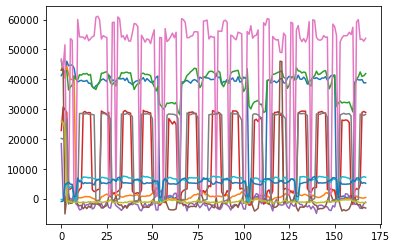

In [61]:
plt.plot(simulator.data['_aux','energy'])
plt.show()

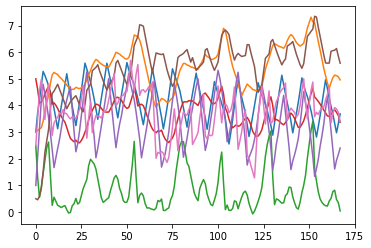

In [62]:
plt.plot(simulator.data['_x'])
plt.show()

# Create MPC

In [68]:
u_max= val_inputs.max()

In [69]:
u_max

PU1      1.0
PU2      1.0
PU3      1.0
PU4      1.0
PU5      1.0
PU6      1.0
PU7      1.0
PU8      1.0
PU9      1.0
PU10     0.7
PU11     0.7
V45     40.0
V47     40.0
V2      70.0
dtype: float32

In [98]:
mpc = do_mpc.controller.MPC(model)

setup_mpc = {
        'n_horizon': 10,
        'n_robust': 0,
        'open_loop': 0,
        't_step': 1.0,
        'store_full_solution': True,
        'state_discretization': 'discrete',
        # Use MA27 linear solver in ipopt for faster calculations:
        'nlpsol_opts': {'ipopt.linear_solver': 'MA27'}
    }

mpc.set_param(**setup_mpc)

lterm = sum1(model.aux['energy'])/1e4
#lterm = sum1((model.x['tank_level']-5)**2)
#mterm = sum1((model.x['tank_level']-5)**2)

mpc.set_objective(lterm = lterm, mterm=DM(0))

mpc.set_rterm(PU=1e-2, V=1e-2)


_ = mpc.set_nl_cons('pressure', -model.aux['pressure'], ub=0)
mpc.set_nl_cons('energy', -model.aux['energy'],ub=0, soft_constraint=True, penalty_term_cons=1e4)
#mpc.set_nl_cons('tank_level', -model.x['tank_level'],ub=0, soft_constraint=True, penalty_term_cons =1e4)

mpc.bounds['lower','_x','tank_level'] = 0
mpc.bounds['upper','_x','tank_level'] = 7
mpc.bounds['lower','_u','PU'] = 0
mpc.bounds['upper','_u','PU'] = 1
mpc.bounds['lower','_u','V'] = 0
mpc.bounds['upper','_u','V'] = np.array([40,40,70])

mpc_tvp = mpc.get_tvp_template()

input_array = val_inputs.to_numpy()
def mpc_tvp_fun(t_now):
    mpc_tvp['_tvp', :, 'cluster_demand'] = horzsplit(val_cluster_demand[int(t_now)+np.arange(mpc.n_horizon+1)].T)
    return mpc_tvp
    
mpc.set_tvp_fun(mpc_tvp_fun)

mpc.setup()

In [99]:
mpc.x0 = val_states.iloc[0].to_numpy()
simulator.x0 = val_states.iloc[0].to_numpy()
mpc.set_initial_guess()

In [100]:
u0 = mpc.make_step(mpc.x0)

This is Ipopt version 3.12.3, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     1547
Number of nonzeros in inequality constraint Jacobian.:    83900
Number of nonzeros in Lagrangian Hessian.............:     2436

Total number of variables............................:      327
                     variables with only lower bounds:      110
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:       77
Total number of inequality constraints...............:     3990
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     3990

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0997160e+04 1.67e+03 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1

  85  1.1019977e+03 6.78e+02 2.22e+03  -1.0 6.22e+01   0.5 3.60e-02 1.05e-02h  1
  86  1.1019795e+03 6.77e+02 3.26e+03  -1.0 6.04e+01   1.0 5.40e-03 9.56e-04h  1
  87  1.1019646e+03 6.50e+02 1.45e+03  -1.0 5.92e+01   0.5 1.23e-02 4.30e-02h  1
  88  1.1019691e+03 6.50e+02 2.74e+03  -1.0 5.67e+01   0.9 8.57e-03 6.19e-04h  1
  89  1.1023467e+03 6.32e+02 1.87e+03  -1.0 5.18e+01   0.4 7.62e-03 2.94e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.1024118e+03 6.27e+02 1.64e+03  -1.0 5.18e+01   0.9 6.38e-03 8.44e-03h  1
  91  1.1031429e+03 5.99e+02 2.36e+03  -1.0 5.70e+01   0.4 2.33e-02 4.92e-02f  1
  92  1.1032301e+03 5.97e+02 2.14e+03  -1.0 3.98e+01   1.7 2.90e-03 3.51e-03h  1
  93  1.1033904e+03 5.91e+02 2.05e+03  -1.0 3.72e+01   1.2 5.43e-03 9.67e-03h  1
  94  1.1034206e+03 5.89e+02 2.53e+03  -1.0 9.08e+01   0.7 1.56e-04 3.11e-03h  1
  95  1.1033988e+03 5.87e+02 3.02e+03  -1.0 3.71e+01   1.2 1.09e-02 3.96e-03h  1
  96  1.1032488e+03 5.84e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.9348872e+04 8.22e+01 1.10e+06  -1.0 1.26e+02   2.0 2.49e-02 8.97e-05h  7
 181  1.9356063e+04 8.22e+01 1.31e+06  -1.0 1.08e+02   2.4 9.64e-03 3.51e-05h 10
 182  1.9357756e+04 8.22e+01 1.42e+06  -1.0 1.24e+02   1.9 1.86e-02 1.15e-05h 12
 183  2.1649419e+04 8.21e+01 1.41e+06  -1.0 1.12e+02   2.3 9.52e-03 9.52e-03s 17
 184  2.0649133e+04 8.16e+01 1.40e+06  -1.0 2.63e+02   1.9 8.97e-03 8.97e-03s 17
 185  2.4241502e+04 8.07e+01 1.37e+06  -1.0 1.76e+02   2.3 1.84e-02 1.84e-02s 17
 186  2.4482765e+04 8.06e+01 1.37e+06  -1.0 1.42e+02   2.7 7.56e-04 7.56e-04s 17
 187  2.4969575e+04 8.05e+01 1.37e+06  -1.0 2.75e+02   2.2 2.17e-03 2.17e-03s 17
 188  2.5511835e+04 8.03e+01 1.37e+06  -1.0 2.33e+02   2.7 2.05e-03 2.05e-03s 17
 189r 2.5511835e+04 8.03e+01 1.00e+03   0.8 0.00e+00   3.1 0.00e+00 0.00e+00R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r 2.7249509e+04 7.24e+01

 274  5.9671163e+03 2.14e+02 5.98e+05  -1.0 7.07e+01   1.1 1.89e-01 1.36e-02h  1
 275  5.7361726e+03 2.04e+02 5.76e+05  -1.0 8.58e+01   0.6 9.82e-02 4.59e-02h  1
 276  5.6947876e+03 2.02e+02 8.12e+05  -1.0 9.12e+01   1.0 2.48e-01 8.56e-03h  2
 277  5.3906105e+03 1.88e+02 7.26e+05  -1.0 1.10e+02   0.6 2.08e-01 6.45e-02h  1
 278  5.3742927e+03 1.88e+02 8.08e+05  -1.0 1.06e+02   1.0 1.38e-01 3.63e-03h  3
 279  5.3634871e+03 1.87e+02 2.50e+06  -1.0 1.00e+02   1.4 6.43e-01 2.32e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  5.2053811e+03 1.79e+02 2.33e+06  -1.0 1.23e+02   0.9 9.64e-02 3.63e-02h  1
 281  5.1984539e+03 1.79e+02 2.35e+06  -1.0 8.26e+01   2.3 4.07e-03 2.18e-03h  2
 282  5.2066571e+03 1.79e+02 2.75e+06  -1.0 2.33e+01   3.6 5.42e-03 9.06e-04h  4
 283  5.2084672e+03 1.79e+02 3.98e+06  -1.0 2.08e+01   4.0 8.30e-03 8.37e-05h  7
 284  5.2095578e+03 1.79e+02 4.36e+06  -1.0 2.86e+01   3.5 3.98e-03 3.38e-05h 10
 285  5.2100500e+03 1.79e+02

 370  2.4779485e+01 1.09e-03 5.56e-03  -3.8 7.90e-01  -3.6 1.00e+00 1.00e+00h  1
 371  2.4760868e+01 7.57e-04 1.14e-02  -3.8 8.48e-01  -4.0 1.00e+00 1.00e+00h  1
 372  2.4715290e+01 8.49e-04 5.07e-03  -3.8 1.63e+00  -4.5 1.00e+00 1.00e+00h  1
 373  2.4634304e+01 5.22e-04 3.92e-03  -3.8 2.58e+00  -5.0 9.90e-01 1.00e+00h  1
 374  2.4578979e+01 1.97e-03 7.07e-03  -3.8 1.63e+01  -5.5 1.00e+00 3.82e-01h  2
 375  2.4527628e+01 2.08e-03 6.31e-04  -3.8 3.42e+00  -5.0 1.00e+00 1.00e+00h  1
 376  2.4523564e+01 3.33e-03 4.02e-03  -3.8 4.12e-01  -3.7 1.00e+00 1.00e+00h  1
 377  2.4518244e+01 1.51e-03 2.65e-03  -3.8 4.09e-01  -4.2 1.00e+00 1.00e+00h  1
 378  2.4507315e+01 4.29e-04 6.08e-04  -3.8 1.23e+00  -4.7 1.00e+00 1.00e+00h  1
 379  2.4477566e+01 9.35e-04 9.37e-04  -3.8 3.70e+00  -5.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380  2.4374918e+01 8.83e-04 1.88e-04  -3.8 1.08e+01  -5.6 1.00e+00 1.00e+00h  1
 381  2.4197423e+01 2.73e-04

 463  2.0144318e+01 3.14e-04 1.52e-03  -5.7 8.65e+00  -6.5 7.46e-01 8.62e-01h  1
 464  2.0135074e+01 1.08e-02 1.28e-04  -5.7 2.02e+01  -7.0 1.00e+00 1.00e+00h  1
 465  2.0122642e+01 5.58e+00 3.31e-03  -5.7 7.32e+01  -7.5 5.48e-01 6.80e-01h  1
 466  2.0106487e+01 4.21e+00 1.40e-02  -5.7 3.85e+01  -7.0 1.00e+00 4.79e-01h  1
 467  2.0094902e+01 5.61e-01 4.39e-02  -5.7 6.63e+01    -  3.05e-01 7.16e-01h  1
 468  2.0087845e+01 3.53e-02 7.13e-03  -5.7 7.39e+00  -6.6 1.00e+00 6.84e-01h  1
 469  2.0085593e+01 6.24e-01 2.40e-02  -5.7 2.38e+01  -7.1 3.86e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470  2.0076380e+01 3.93e-01 1.98e-03  -5.7 1.21e+01  -6.7 9.22e-01 1.00e+00h  1
 471  2.0074621e+01 4.59e-01 5.51e-03  -5.7 9.69e+01  -7.1 2.17e-01 3.74e-02h  2
 472  2.0070850e+01 2.00e+00 2.04e-02  -5.7 1.79e+02  -7.6 5.13e-01 5.78e-02h  1
 473  2.0065613e+01 1.58e-01 4.71e-03  -5.7 4.09e+01    -  1.00e+00 4.77e-01h  1
 474  2.0064034e+01 4.09e-01

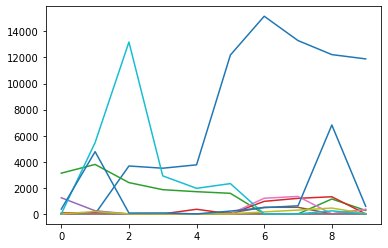

In [95]:
plt.plot(mpc.data.prediction(('_aux','energy'),-1).squeeze().T)
plt.show()

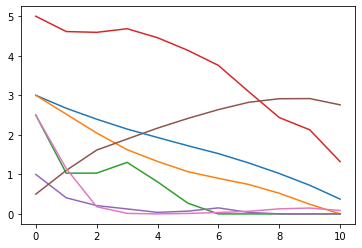

In [96]:
plt.plot(mpc.data.prediction(('_x',),-1).squeeze().T)

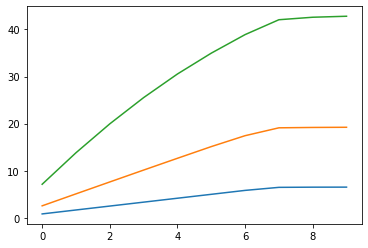

In [97]:
plt.plot(mpc.data.prediction(('_u','V'),-1).squeeze().T)